In [68]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import operator
import toposort

# 1. Discover Asymmetrix Relationships
Naturally, a directed edge is an edge that has a direction: it connects node X to node Y, but not the other way around. Mathematically, the relationship represented by a directed edge is asymmetric.
## 1.1 Signed or not signed
||Gigned (-)|Unsigned|Signed(+)
|:-|:-|:-|:-
|Directed|Alice hates Bob (but Bob does not hate Alice)|Alice knows Bob (but Bob does not know Alice)|Alice likes Bob (but Bob does not like Alice)
|Undirected|Alice and Bob are foes|Alice and Bob are acquaintances|Alice and Bob are friends

In [10]:
# load state-to-state migration data of US
migration_df = pd.read_csv(r'E:\OneDrive - 同济大学\03 - 阅读\network analysis\complex network analysis in python_code\code\migration_2015.csv')
migration_df.drop(columns = 'Unnamed: 0', inplace = True)
migration_df.index = migration_df.columns

# convert the migration data to an origin-destination-weight table, and for each origin reserve only the top 3 weighted edges
migration_table = migration_df.stack().reset_index().sort_values(0, ascending = False).groupby('level_0').head(3).reset_index()
migration_table.drop('index', axis = 1, inplace = True)
migration_table.columns = ['Origin', 'Destination', 'Weight']


# convert migration data into graph
G = nx.DiGraph()
G.add_weighted_edges_from([(migration_table.loc[i]['Origin'], migration_table.loc[i]['Destination'], migration_table.loc[i]['Weight']) for i in range(len(migration_table))])

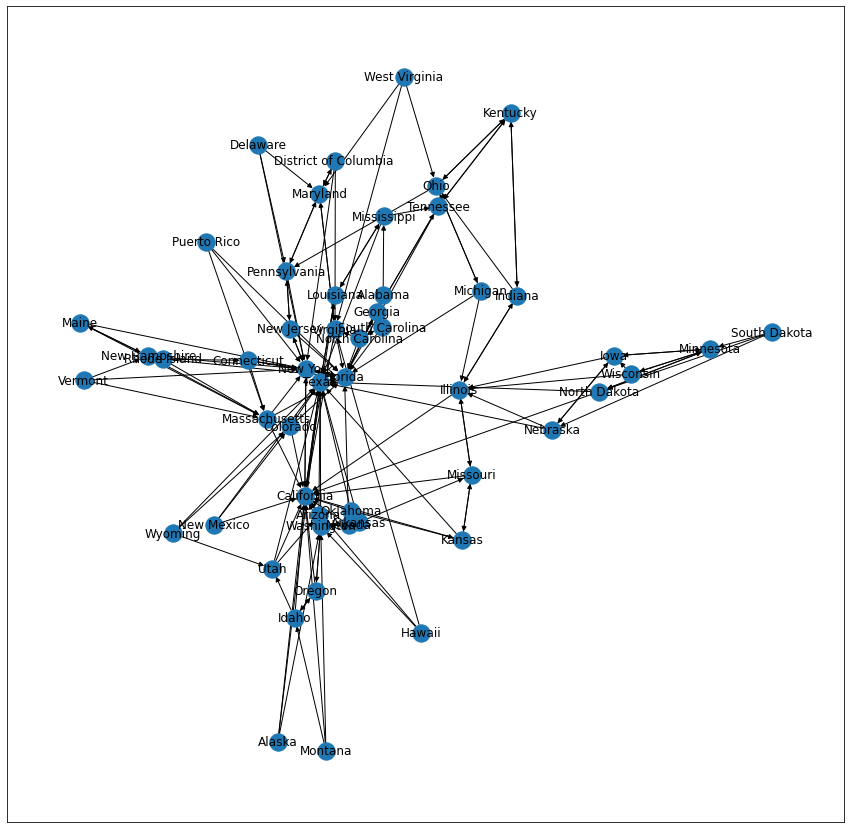

In [11]:
# draw the graph
fig = plt.figure(figsize = (15,15))
ax = plt.subplot()
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, ax = ax)

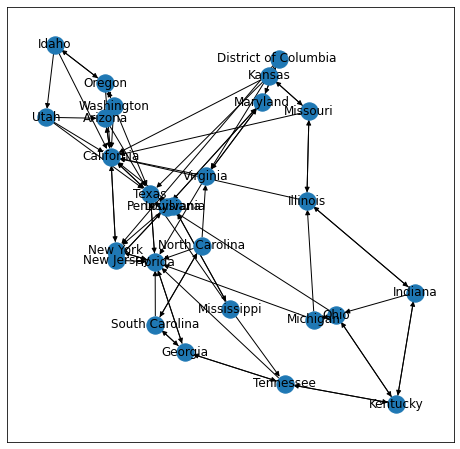

In [12]:
# construct an egocentric graph of California
G_ca = nx.ego_graph(G, 'California', radius = 100000)# the default radius is 1. Remember to designate a large enough radius. 
fig = plt.figure(figsize = (8,8))
ax = plt.subplot()
pos = nx.spring_layout(G_ca)
nx.draw_networkx(G_ca, pos, ax = ax)

# 2. Explore Directed Networks
## 2.1 Degree
Each node in a directed graph G has three degrees: **G.in_degree()** (the number of incoming incident edges), **G.out_degree()** (the number of outgoing incident edges), and the total **G.degree()** (the number of all edges). Note that the total degree is the sum of the indegree and outdegree.

In [13]:
# elements in G.out_degree(weight = 'weight') are tuples:
list(G.out_degree(weight = 'weight'))

[('Florida', 137649.0),
 ('New York', 86290.0),
 ('Texas', 130260.0),
 ('California', 112813.0),
 ('Nevada', 67279.0),
 ('Arizona', 81854.0),
 ('New Jersey', 83447.0),
 ('Georgia', 82768.0),
 ('Washington', 91008.0),
 ('Pennsylvania', 91859.0),
 ('Oregon', 71879.0),
 ('Indiana', 60547.0),
 ('Illinois', 48821.0),
 ('North Carolina', 86482.0),
 ('Virginia', 76346.0),
 ('South Carolina', 63240.0),
 ('Louisiana', 38276.0),
 ('Colorado', 66920.0),
 ('Oklahoma', 46453.0),
 ('Maryland', 61272.0),
 ('Alabama', 50630.0),
 ('Missouri', 54395.0),
 ('Connecticut', 39440.0),
 ('Wisconsin', 48867.0),
 ('Massachusetts', 44368.0),
 ('District of Columbia ', 27887.0),
 ('Kansas', 35554.0),
 ('Minnesota', 33566.0),
 ('Iowa', 35319.0),
 ('New Hampshire', 27507.0),
 ('Idaho', 32848.0),
 ('Utah', 34502.0),
 ('Tennessee', 46210.0),
 ('Arkansas', 31580.0),
 ('Ohio', 43648.0),
 ('Kentucky', 37294.0),
 ('Michigan', 39392.0),
 ('Delaware', 25473.0),
 ('North Dakota', 20281.0),
 ('Rhode Island', 20876.0),
 ('New

In [14]:
# calculate the degrees via weighted value
print(sorted(G.out_degree(weight = 'weight'), key = operator.itemgetter(1), reverse = True)[:3])
print(sorted(G.in_degree(weight = 'weight'), key = operator.itemgetter(1), reverse = True)[:3])
print(sorted(G.degree(weight = 'weight'), key = operator.itemgetter(1), reverse = True)[:3])

[('Florida', 137649.0), ('Texas', 130260.0), ('California', 112813.0)]
[('California', 464135.0), ('Florida', 278433.0), ('New York', 258179.0)]
[('California', 576948.0), ('Florida', 416082.0), ('Texas', 371443.0)]


In [15]:
# calculate the degrees via the number of edges
print(sorted(G.out_degree(), key = operator.itemgetter(1), reverse = True)[:3])
print(sorted(G.in_degree(), key = operator.itemgetter(1), reverse = True)[:3])
print(sorted(G.degree(), key = operator.itemgetter(1), reverse = True)[:3])

[('Florida', 3), ('New York', 3), ('Texas', 3)]
[('California', 21), ('Florida', 17), ('Texas', 16)]
[('California', 24), ('Florida', 20), ('Texas', 19)]


## 2.2 Neighbors
A node in a directed graph has two types of neighbors: G.successors()(reachable through the outgoing edges) and G.predecessors()(reachable through the incoming edges). The method G.neighbors() is another name of G.successors().


In [16]:
final_destination = sorted(G.in_degree(weight = 'weight'), key = operator.itemgetter(1), reverse = True)[0][0]
coming_from = list(G.predecessors(final_destination))
going_to = list(G.successors(final_destination))
print('Final destination is {}'.format(final_destination))
print(coming_from)
print(going_to)

Final destination is California
['Texas', 'Nevada', 'Arizona', 'Washington', 'Oregon', 'Colorado', 'New York', 'Virginia', 'Illinois', 'Idaho', 'Utah', 'Hawaii', 'Missouri', 'Massachusetts', 'Oklahoma', 'Louisiana', 'New Mexico', 'Kansas', 'Montana', 'Alaska', 'North Dakota']
['Texas', 'New York', 'Arizona']


## 2.3 Walks, trails and paths
A walk in a directed network is still any sequence of edges such that the end of one edge is the beginning of another edge. However, a directed edge has only one end and one beginning.
## 2.4 Centralities and other distances
Each node in a directed graph has three degree centralities (**G.in_degree_centrality()**, **G.out_degree_centrality()**, and **G.degree_centrality()**). 
The other types of centralities—closeness, betweenness, and eigenvector—are calculated the same way for directed and undirected networks, but the results, in general, differ because of the different neighborhoods and paths. The latter
is also true about the center, diameter, radius, eccentricity, and the periphery of a graph.
## 2.5 Components
In a strongly connected component, any member node is reachable from any other member node. (There is a migration flow from any state to any state, perhaps through some intermediate states in the same component.) In a weakly connected component, any member node would be reachable from any other member node if all edges were converted to undirected. (There is a migration flow either from or to any state, perhaps through some intermediate states in the same component.)

Function **<mark>nx.condensation(G)</mark>** calculates the condensation of G. <u>A condensation is an induced directed graph whose nodes represent strongly connected components of G, and edges represent bundles of the original edges.</u> All original graph nodes within an induced node of the condensation are definitely reachable from each other. If your goal is to study graph reachability, replacing a strongly connected component with one node does not affect your findings, but makes the problem simpler.

A strongly connected component is called *attracting* if it has no outgoing edges whatsoever. Networkx offers functions **<mark>nx.attracting_components(G)</mark>** and **<mark>nx.attracting_component_subgraphs(G)</mark>** to obtain the attracting components. 

In [17]:
weakly_connected_subgraph = list(nx.weakly_connected_components(G))
strongly_connected_subgraph = list(nx.strongly_connected_components(G))
print(weakly_connected_subgraph)
print(strongly_connected_subgraph)

[{'Tennessee', 'Florida', 'Maryland', 'Virginia', 'Nebraska', 'Alaska', 'Alabama', 'Oregon', 'Idaho', 'Kentucky', 'Colorado', 'Kansas', 'Puerto Rico', 'New Hampshire', 'New Jersey', 'Vermont', 'Indiana', 'Hawaii', 'Washington', 'North Carolina', 'Montana', 'New York', 'Rhode Island', 'Wyoming', 'Utah', 'West Virginia', 'Delaware', 'North Dakota', 'Minnesota', 'District of Columbia ', 'Wisconsin', 'Mississippi', 'Connecticut', 'Maine', 'Massachusetts', 'Georgia', 'Arkansas', 'Louisiana', 'South Dakota', 'Iowa', 'Missouri', 'Nevada', 'Texas', 'Oklahoma', 'South Carolina', 'California', 'Pennsylvania', 'New Mexico', 'Arizona', 'Michigan', 'Illinois', 'Ohio'}]
[{'Tennessee', 'Florida', 'Maryland', 'Virginia', 'Oregon', 'Kentucky', 'Illinois', 'Kansas', 'New Jersey', 'Indiana', 'Washington', 'North Carolina', 'New York', 'Utah', 'District of Columbia ', 'Mississippi', 'Georgia', 'Louisiana', 'Missouri', 'Texas', 'California', 'Pennsylvania', 'South Carolina', 'Arizona', 'Michigan', 'Idaho',

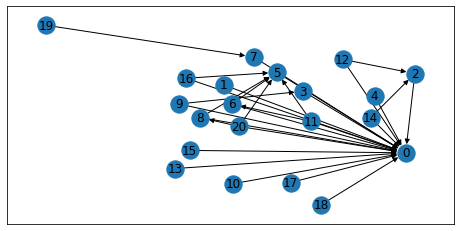

In [18]:
# generate the condensed graph of G
G_condense = nx.condensation(G)
fig = plt.figure(figsize = (8,4))
ax = plt.subplot()
pos = nx.spring_layout(G_condense)
nx.draw_networkx(G_condense, pos, ax = ax)

In [19]:
# obtain the attracting components
attract_subgraph = list(nx.attracting_components(G))
print(attract_subgraph)

[{'Tennessee', 'Florida', 'Maryland', 'Virginia', 'Oregon', 'Kentucky', 'Illinois', 'Kansas', 'New Jersey', 'Indiana', 'Washington', 'North Carolina', 'New York', 'Utah', 'District of Columbia ', 'Mississippi', 'Georgia', 'Louisiana', 'Missouri', 'Texas', 'California', 'Pennsylvania', 'South Carolina', 'Arizona', 'Michigan', 'Idaho', 'Ohio'}]


## 2.6 Reversal and flattening
You can reverse a directed graph with the method **<mark>G.reverse()</mark>**, which returns a copy of the original graph with each edge reversed. 

Finally, Networkx provides a tool for getting rid of directedness altogether. Method **<mark>G.to_undirected(reciprocal=False)</mark>** returns an undirected copy of a directed graph. If the parameter *reciprocal* is True, the function keeps only the edges that appear in both directions in the original digraph.

# 3. Apply topological sort to directed acyclic graphs
A <mark><u>**directed acyclic graph (DAG)**</u></mark> is an acyclic directed network - <u>a network that does not contain any cycles</u> (cycle: a trail that does not intersect itself, but starts and ends at the same node). Visually, DAG is a tree, a forest, or a star, or a linear graph.

Directed acyclic graphs describe hierarchies - system in which their components are ranked one above the other according to some property (a hierarchy is often informally referred to as a "pecking order": who pecks whom?). In a hierarchy, any two components A and B are either unrelated, or A is unambiguously subordinated to B, or B is unambiguously subordinated to A, either directly or indirectly.

All NetworkX functions and techniques for directed networks naturally work for DAGs, but several functions are intended solely for DAGs. Function <mark>**nx.is_directed_acyclic_graph(G)**</mark> checks if G is a DAG or not. Function <mark>**nx.transitive_closure(G)**</mark> calculates a transitive closure T of G: <u> a graph that has the same nodes as G such that 2 nodes in T are adjacent if and only if there is a path between the 2 nodes in G.</u> Think of a transitive closure as a graph of all possible subordination relationships, both direct and indirect. 

You can serialize a DAG and arrange all nodes in a linear order, so that the next node may be a subordinate of the previous node, but the previous node is never a subordinate of the next node. The result of the serialization is a ranking of all nodes, with the source nodes at the beginning and target nodes at the end. This operation is called "topological sort". You can sort a DAG in many different ways, resulting in different "pecking orders". Function <mark>**nx.topological_sort(G)**</mark> returns one randomly chosen ranking as a list of node labels. 
- a topological sort order is not too useful because it focuses on what is impossible rather than on what is definite. You can tell the high ranking nodes are not subordinates of low ranking nodes, yet you cannot low ranking nodes are unquestionably subordinates of high ranking nodes.

## 3.1 Master "toposort"
Game developers and creative writers are often in need of a collection of adjectives that characterize a particular property and range from “very bad” to “very good.” Directed network analysis (via the module toposort) makes it possible to design such a scale in any natural language. Following is the case study.

In [20]:
'''
first, you have to design the questionnaire in such a way that 
the takers either rank all words in the order from the “best” to the “worst” or
assign a numerical measure of “goodness” to each word.

tha samples are collected as a CSV file
'''
# cleanse the data
rank = pd.read_csv(r'E:\OneDrive - 同济大学\03 - 阅读\network analysis\complex network analysis in python_code\code\Adjectives_by_the_rank.csv'
                  ,header = 1).set_index('ResponseID').fillna(0)
Q1 = "Rank the words from the most positive to the most negative-"
ranks = rank.loc[:,rank.columns.str.startswith(Q1)].astype(int)
ranks.columns = ranks.columns.str.replace(Q1, "")         
ranks

,good,bad,great,horrible,first-class,alpha plus,excellent,exciting,f*cking good,filthy,...,shitty,crappy,pathetic,unfit,worthless,repugnant,mediocre,normal,average,fantastic
ResponseID,,,,,,,,,,,,,,,,,,,,,
R_5uRs6Q3FPhjBuQZ,15,25,4,30,8,10,6,5,7,31,...,32,29,26,28,27,33,22,18,19,2
R_27yafUr22gg2CEn,15,24,3,29,9,8,12,1,7,30,...,31,32,28,27,26,33,22,18,19,2
R_po7YBFa9x003JwR,11,25,7,32,8,12,3,1,9,13,...,30,29,26,28,27,33,21,19,20,2
R_0f7bvNBl6QoGwWl,15,26,11,32,6,8,12,4,10,31,...,28,29,25,22,27,33,24,18,19,2
R_2fBQZMyuotsqmth,11,23,5,24,6,14,4,1,3,25,...,30,29,20,22,21,27,31,32,33,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R_2xJnLt2faGNkcPu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R_C9xRdD6AkIjNhAJ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R_1r02C8XOMVlZdVq,15,24,10,29,6,9,7,11,4,31,...,33,30,26,27,25,32,19,18,20,3


Each column of the DF ranks represents the ranks of a word from each participant. Connect the word *i* to another word *j* with a directed edge if the participants agree, to some degree, that *i* is better than *j*. 

The definition of what constitutes the agreement may be stringent (by consensus), weak (when at least two participants agree), or somewhere in the middle (say, at least 115 of 158 participants agree).

In order to prevent thr graph from being too hairy or too sparse, we apply the third criterion.

In [52]:
# construct the directed edge list
edges = []
for i in ranks.columns:
    for j in ranks.columns:
        if i is j:
            continue
        else:
            if sum(ranks[i]>ranks[j]) >= 115:
                edges.append((j,i))
            else:
                continue

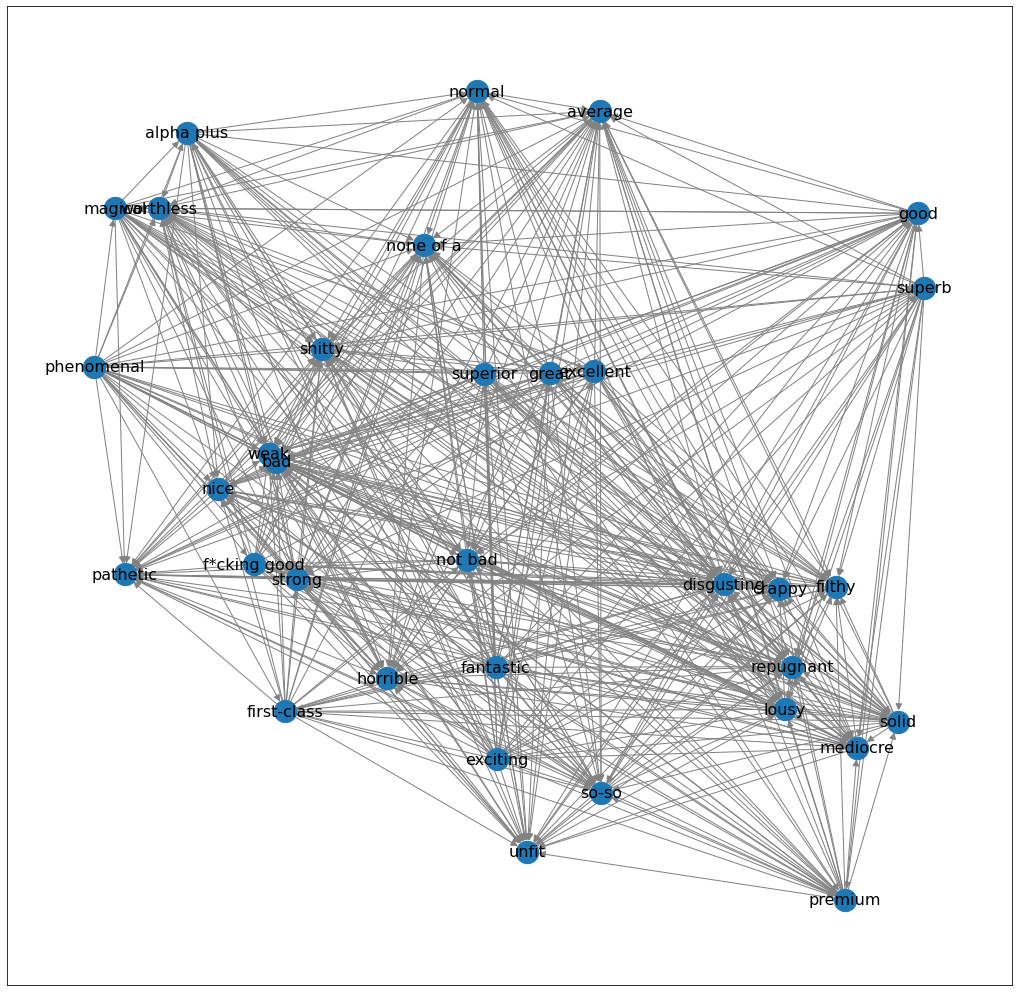

In [59]:
# convert the edge list into a graph
G0 = nx.DiGraph()
G0.add_edges_from(edges)

# draw the graph
pos = nx.random_layout(G0)
fig = plt.figure(figsize = (18,18))
ax = plt.subplot()
nx.draw_networkx(G0, pos = pos, edge_color = (0.51,0.51,0.51), node_size = 500, font_size = 16, arrowsize = 14, ax = ax)

In [61]:
# this graph is a DAG
nx.is_directed_acyclic_graph(G0)

True

In [65]:
# execute topological sort
print(list(nx.topological_sort(G0)))

['fantastic', 'phenomenal', 'magical', 'f*cking good', 'exciting', 'superior', 'superb', 'excellent', 'alpha plus', 'first-class', 'premium', 'great', 'strong', 'solid', 'good', 'normal', 'not bad', 'nice', 'average', 'mediocre', 'so-so', 'none of a', 'weak', 'worthless', 'unfit', 'pathetic', 'bad', 'lousy', 'crappy', 'shitty', 'filthy', 'horrible', 'repugnant', 'disgusting']


The only problem with the function *nx.topological_sort(G)* is that it returns only one possible topological sort order. It forcefully ranks the nodes that are otherwise topologically equivalent, adding unnecessary constraints to the way the node labels can be used. 

The module *toposort* provides the function **<mark>toposort.toposort(edge_dict)</mark>** that does not have the limitations of the function nx.topological_sort(). This function returns a generator of sets of topologically equivalent nodes. A node in a set does not dominate and is not dominated by any node in the same set.

In [83]:
edge_dict = { key:set(value) for key, value in nx.to_dict_of_lists(G0).items()}
topo_order = list(toposort.toposort(edge_dict))
print(topo_order)

[{'crappy', 'disgusting', 'repugnant'}, {'horrible', 'filthy', 'shitty'}, {'worthless', 'lousy', 'pathetic'}, {'unfit', 'bad'}, {'weak', 'mediocre'}, {'none of a', 'so-so'}, {'average'}, {'not bad', 'nice', 'normal'}, {'strong', 'solid', 'good'}, {'excellent', 'premium', 'alpha plus', 'great'}, {'f*cking good', 'superior', 'magical', 'superb', 'first-class'}, {'exciting', 'phenomenal', 'fantastic'}]
